In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [31]:
batch_num = 8
hidden_num = 15
step_num = 10
elem_num = 34
init_wins = 6000

names = [str(x) for x in range(elem_num)] +["label"]
smtp = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/smtp.csv",names=names,skiprows=step_num*init_wins)
http = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/http_new.csv",names=names)
smtp_http = pd.concat((smtp,http),axis=0)
batches = smtp_http.shape[0]//step_num//batch_num
test_set = smtp_http.iloc[:batches*batch_num*step_num,:-1]
labels =smtp_http.iloc[:batches*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]

In [36]:
smtp.shape[0] / (smtp.shape[0] + http.shape[0])

0.05541465485223113

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del smtp_http
del smtp
del http
del test_set

In [5]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[7, 226, 841, 1039, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1695, 1711, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1970, 2597, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 8446, 8447, 8916, 9613, 9925, 10779, 10780, 10781, 10782, 1078

# Load Model

In [69]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/smtp_8_15_10/"
modelmeta_p = modelpath_root + "_8_15_10_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")
tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/smtp_8_15_10/_8_15_10_para.ckpt


In [7]:
print(mu.shape,sigma.shape,threshold)

(34,) (34, 34) 0.0945808


# Online Phase (With expert)

In [8]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [9]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [10]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [11]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = upper
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate -= delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

0 : 0 ,  0
retrain at 51 batch
Parameters updated! new threshold 0.095
100 : 90 ,  0
200 : 290 ,  20
300 : 540 ,  500
400 : 790 ,  720
500 : 2830 ,  830
retrain at 525 batch
Parameters updated! new threshold 0.095
600 : 50 ,  0
700 : 60 ,  510
800 : 90 ,  510
900 : 160 ,  510
1000 : 350 ,  720
1100 : 1840 ,  740
1200 : 2690 ,  750
1300 : 3040 ,  770
1400 : 3640 ,  1400
retrain at 1422 batch
Parameters updated! new threshold 0.095
1500 : 430 ,  210
1600 : 980 ,  220
1700 : 1280 ,  530
1800 : 1490 ,  530
1900 : 1650 ,  530
2000 : 1860 ,  530
2100 : 2080 ,  530
2200 : 2320 ,  530
2300 : 2510 ,  530
2400 : 2670 ,  530
2500 : 2760 ,  530
2600 : 2870 ,  530
2700 : 2940 ,  530
2800 : 3000 ,  530
2900 : 3130 ,  530
3000 : 3210 ,  530
3100 : 3350 ,  530
3200 : 3470 ,  530
3300 : 3670 ,  530
3400 : 3750 ,  530
3500 : 3840 ,  530
3600 : 3980 ,  530
retrain at 3618 batch
Parameters updated! new threshold 0.095
3700 : 0 ,  0
3800 : 0 ,  0
3900 : 0 ,  0
4000 : 10 ,  0
4100 : 10 ,  0
4200 : 10 ,  0
4

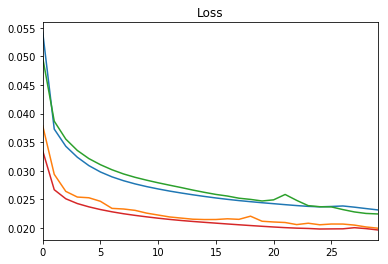

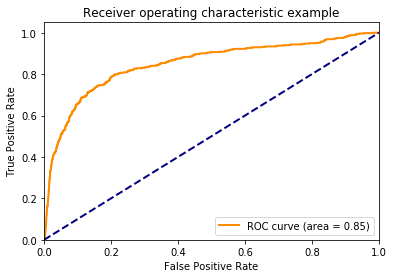

--- Initialization time: 1002.9478862285614 seconds ---
Updating index:  [51, 525, 1422, 3618]


In [42]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []

start_time = time.time()

normal_score_buf = []
nsb = []
updating_index = []
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
        if count % 100 == 0:
            print(count,":",len(n_buf),", ",len(a_buf))
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
#        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        for tmp_i in range(batch_num):
            if label[tmp_i] =="normal":
                nsb += scores[tmp_i*step_num:(tmp_i+1)*step_num]
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=4: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        foot = batch_num*step_num*50
        if len(n_buf)>=foot and len(a_buf) !=0:
            updating_index.append(count)
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            #err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            #mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)   

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
            normal_score_buf.append(nsb)
            nsb = []
normal_score_buf.append(nsb)               
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))
print("Updating index: ",updating_index)

In [67]:
len(expert)/8

8245.0

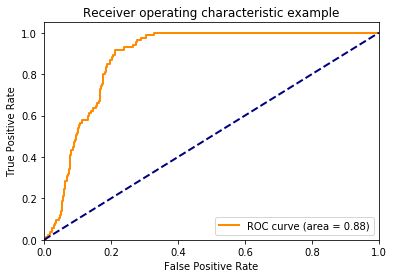

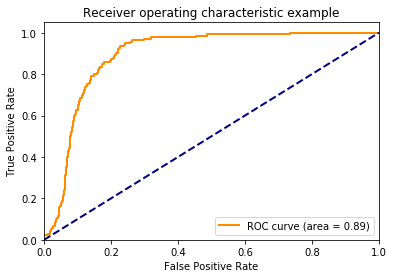

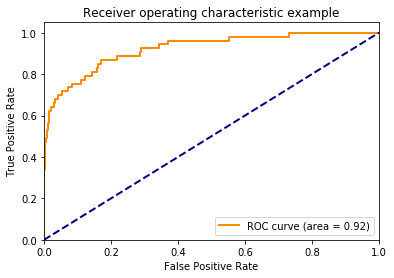

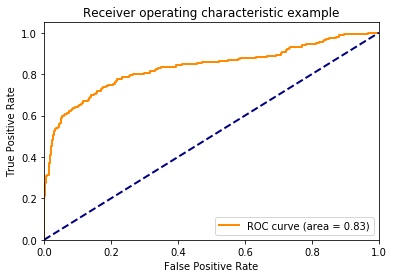

[0.88002573082696012, 0.89128055713473564, 0.92252139675426459, 0.83336262304716757]


In [68]:
updating_index = [0, 525, 1422, 3618,8245]
tmp = []
for ui in range(len(updating_index)-1):
    
    fpr, tpr, thresholds = metrics.roc_curve(expert[updating_index[ui]*8:updating_index[ui+1]*8],output[updating_index[ui]*8:updating_index[ui+1]*8], pos_label="anomaly")
    auc = metrics.auc(fpr, tpr)
    #print(fpr,tpr,thresholds,auc)
    plot_roc(fpr,tpr,auc)
    tmp.append(auc)
print(tmp)

<function matplotlib.pyplot.show>

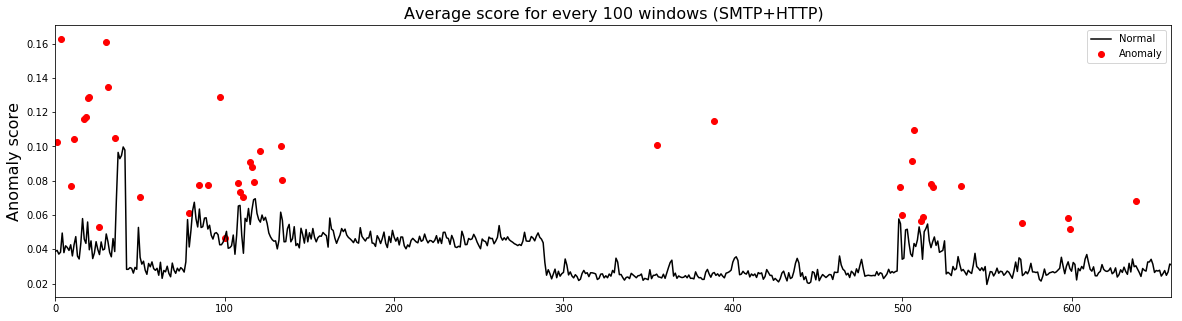

In [63]:
real = pd.Series(expert)
pred = pd.Series(output)
for ind in real[real == "anomaly"].index:
    pred[ind] = sum([x for x in pred[ind-5:ind+5]])/10
    
anomalies= pd.Series(output)[real=="anomaly"]
fooh = pd.Series(anomalies.index)
redPoints = []
for hd in range(len(pred)//100) :
    tmp_ = pd.Series(anomalies.index)[pd.Series(anomalies.index)>hd*100]
    
    if tmp_[tmp_<(hd+1)*100].shape[0]!=0:
        toavg = []
        for xx in tmp_[tmp_<(hd+1)*100]:
             toavg.append(anomalies[xx])
        redPoints.append([hd+1,pd.Series(toavg).mean()])
        
        
i = 0
result = []
while i < pred.shape[0]//100:
    result.append(pred[i*100:(i+1)*100].mean())
    i+=1
result.append(pred[i*100:].mean())
result[:4] = pd.Series([x/4 for x in result[:4]])
pd.Series(result).plot(figsize=(20,5),label="Normal",c='black')
plt.title("Average score for every 100 windows (SMTP+HTTP)", fontsize=16)
plt.scatter(np.array(redPoints)[:,0],np.array(redPoints)[:,1],c='r',label="Anomaly")
plt.legend()
plt.ylabel("Anomaly score",fontsize=16)
#plt.xticks([])
plt.show

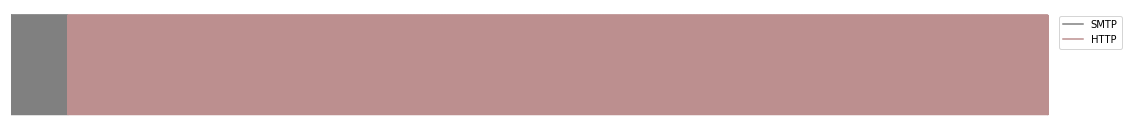

In [62]:
classlabel = pd.Series(['s' for _ in range(36554)] +['h' for _ in range(623091)])
ls =  pd.Series(np.zeros(classlabel[classlabel=='s'].shape[0]))
ls[::80] = 1
lh = pd.Series(np.zeros(classlabel[classlabel=='h'].shape[0]))
lh[::80] = 1

plt.figure(figsize=(20,2))
plt.xlim(0,classlabel.shape[0]+50000)
plt.plot(ls,c="grey",label="SMTP")
plt.plot( pd.Series(classlabel[classlabel=='h']).index,lh,c="rosybrown",label="HTTP")

plt.legend()
plt.yticks([])
plt.xticks([])
plt.axis('off')
plt.show()

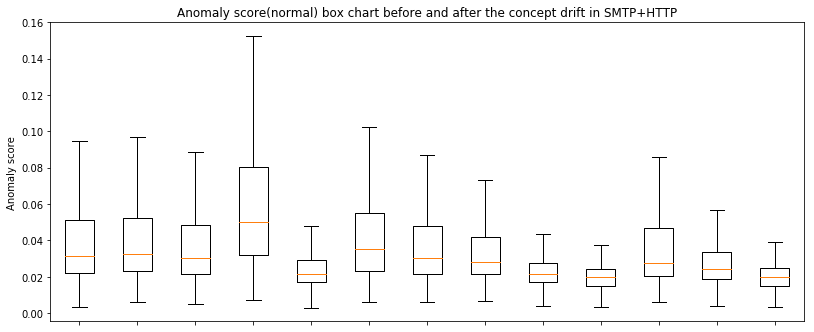

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(13.5, 5.5)
ax.boxplot(foo,0,"")
ax.set_xticklabels([])
ax.set_ylabel("Anomaly score")
ax.set_title("Anomaly score(normal) box chart before and after the concept drift in SMTP+HTTP")
plt.show()

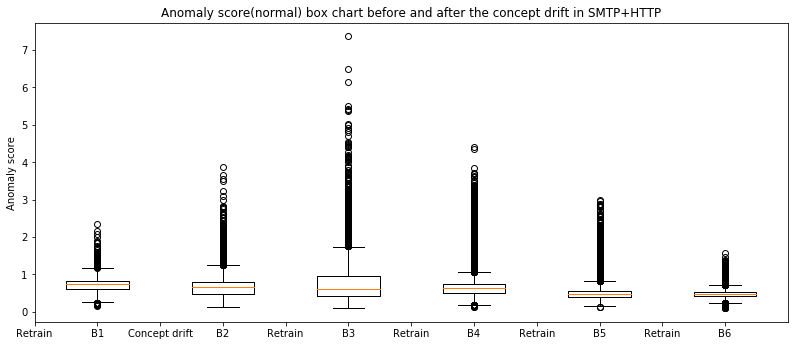

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(13.5, 5.5)
ax.boxplot(box_buf)
ax.set_xticks([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6])
ax.set_xticklabels(["Retrain","B1","Concept drift","B2","Retrain","B3","Retrain","B4","Retrain","B5","Retrain","B6"])
ax.set_ylabel("Anomaly score")
ax.set_title("Anomaly score(normal) box chart before and after the concept drift in SMTP+HTTP")
plt.show()

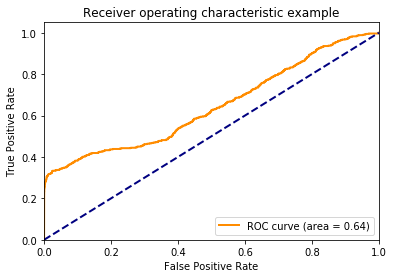

--- Initialization time: 77.49984669685364 seconds ---


In [70]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []

start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
#        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err


fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

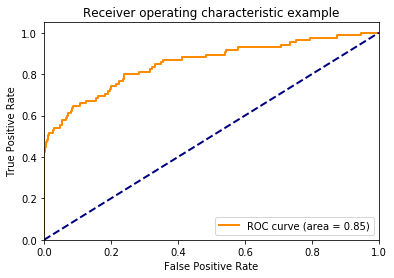

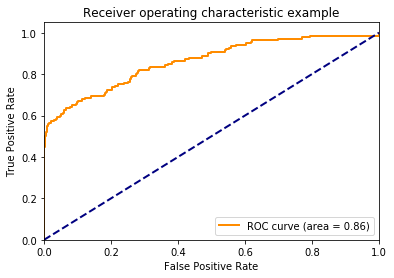

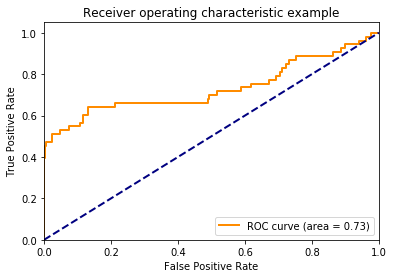

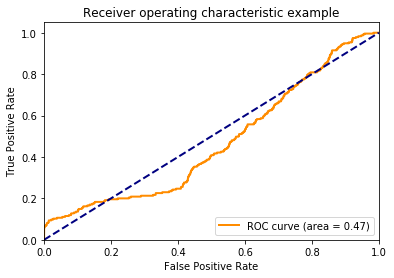

[0.85271388749910648, 0.86127974498497517, 0.73172859920607136, 0.46945370152374]


In [71]:
updating_index = [0, 525, 1422, 3618,8245]
tmp = []
for ui in range(len(updating_index)-1):
    
    fpr, tpr, thresholds = metrics.roc_curve(expert[updating_index[ui]*8:updating_index[ui+1]*8],output[updating_index[ui]*8:updating_index[ui+1]*8], pos_label="anomaly")
    auc = metrics.auc(fpr, tpr)
    #print(fpr,tpr,thresholds,auc)
    plot_roc(fpr,tpr,auc)
    tmp.append(auc)
print(tmp)